In [4]:
from torchvision import datasets
import torch
import matplotlib.pyplot as plt

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)

Files already downloaded and verified


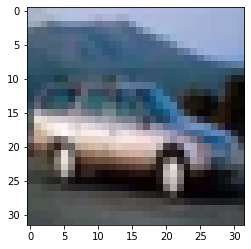

In [5]:
img, label = cifar10[4]
plt.imshow(img)
plt.show()

In [6]:
from torchvision import transforms

to_tensor = transforms.ToTensor()
img_t = to_tensor(img) # turning image to tensor to pass it to NeuralNet
img_t.shape # 3 channels of RGB, 32x32 size

torch.Size([3, 32, 32])

In [7]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                          transform=transforms.ToTensor())

In [8]:
# stacking tensors in additional dimension
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [9]:
std = imgs.view(3, -1).std(dim=1)
std

tensor([0.2470, 0.2435, 0.2616])

In [10]:
mean = imgs.view(3, -1).mean(dim=1) 
mean

tensor([0.4914, 0.4822, 0.4465])

In [11]:
from torchvision import transforms
from torch.utils.data import random_split

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

val_size = 5000
train_size = len(cifar10) - val_size

train_ds, val_ds = random_split(cifar10, [train_size, val_size])

test_ds = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [26]:
from torch.utils.data.dataloader import DataLoader

batch_size=128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [27]:
from torch.nn import Module
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

n_out = len(cifar10.classes)
n_in = 3072


class MLP(Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.linear1 = nn.Linear(n_in, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 64)
        self.linear5 = nn.Linear(64, n_out)
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

In [40]:
from numpy import hstack
from sklearn.metrics import accuracy_score


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_acc(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        yhat = model(inputs)
        yhat = yhat.detach().cpu().numpy()
        actual = targets.cpu().numpy()
        
        yhat = np.argmax(yhat, axis=1)
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = hstack(predictions), hstack(actuals)

    return accuracy_score(actuals, predictions)


def train_model(train_dl, val_dl, epochs, model, criterion, optimizer):
    history = []
    for epoch in range(epochs):
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            yhat = model(inputs)
            loss = criterion(yhat, targets)
            if i % 100 == 0:
                print(f'epoch: {epoch} Loss after mini-batch {i}: {loss}')
            loss.backward()
            optimizer.step()

        acc = get_acc(val_dl, model)
        print(f'epoch: {epoch} accuracy: {acc}')
        history.append(acc)

    return history

In [41]:
model = MLP(n_in, n_out)
model.to(device)
train_model(train_dl, val_dl, 1, model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-3))
acc = get_acc(test_dl, model)
print('Accuracy: %.3f' % acc)

epoch: 0 Loss after mini-batch 0: 2.303844451904297
epoch: 0 Loss after mini-batch 100: 1.7682790756225586
epoch: 0 Loss after mini-batch 200: 1.5724176168441772
epoch: 0 Loss after mini-batch 300: 1.7933597564697266
epoch: 0 accuracy: 0.4438
Accuracy: 0.462


In [42]:
class Net(nn.Module):
    def __init__(self, n_out):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, n_out))
        
    def forward(self, x):
        return self.network(x)

epoch: 0 Loss after mini-batch 0: 2.318315029144287
epoch: 0 Loss after mini-batch 100: 1.408901572227478
epoch: 0 Loss after mini-batch 200: 0.8727184534072876
epoch: 0 Loss after mini-batch 300: 0.9203012585639954
epoch: 0 accuracy: 0.7054
epoch: 1 Loss after mini-batch 0: 0.8985525369644165
epoch: 1 Loss after mini-batch 100: 0.6706856489181519
epoch: 1 Loss after mini-batch 200: 0.6346564292907715
epoch: 1 Loss after mini-batch 300: 0.6911699771881104
epoch: 1 accuracy: 0.7776
epoch: 2 Loss after mini-batch 0: 0.4727267026901245
epoch: 2 Loss after mini-batch 100: 0.41165152192115784
epoch: 2 Loss after mini-batch 200: 0.4722711443901062
epoch: 2 Loss after mini-batch 300: 0.351956844329834
epoch: 2 accuracy: 0.8044
epoch: 3 Loss after mini-batch 0: 0.3189420998096466
epoch: 3 Loss after mini-batch 100: 0.3167969584465027
epoch: 3 Loss after mini-batch 200: 0.3822961449623108
epoch: 3 Loss after mini-batch 300: 0.39171579480171204
epoch: 3 accuracy: 0.812
epoch: 4 Loss after mini-b

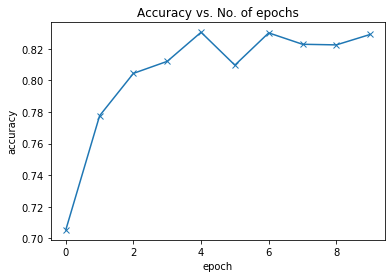

In [45]:
def plot_accuracies(history):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

model = Net(n_out)
model.to(device)
history = train_model(train_dl, val_dl, 10, model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-3))
acc = get_acc(test_dl, model)
print('Accuracy: %.3f' % acc)
plot_accuracies(history)

epoch: 0 Loss after mini-batch 0: 2.2968695163726807
epoch: 0 Loss after mini-batch 100: 1.9593614339828491
epoch: 0 Loss after mini-batch 200: 1.6206046342849731
epoch: 0 Loss after mini-batch 300: 1.4405831098556519
epoch: 0 accuracy: 0.4902
epoch: 1 Loss after mini-batch 0: 1.369407057762146
epoch: 1 Loss after mini-batch 100: 1.2959461212158203
epoch: 1 Loss after mini-batch 200: 1.243977427482605
epoch: 1 Loss after mini-batch 300: 1.2282657623291016
epoch: 1 accuracy: 0.5754
epoch: 2 Loss after mini-batch 0: 1.1607130765914917
epoch: 2 Loss after mini-batch 100: 1.0505067110061646
epoch: 2 Loss after mini-batch 200: 1.2219914197921753
epoch: 2 Loss after mini-batch 300: 0.8703412413597107
epoch: 2 accuracy: 0.6154
epoch: 3 Loss after mini-batch 0: 0.9271619915962219
epoch: 3 Loss after mini-batch 100: 0.7728339433670044
epoch: 3 Loss after mini-batch 200: 0.9491371512413025
epoch: 3 Loss after mini-batch 300: 0.9204367995262146
epoch: 3 accuracy: 0.6394
epoch: 4 Loss after mini-b

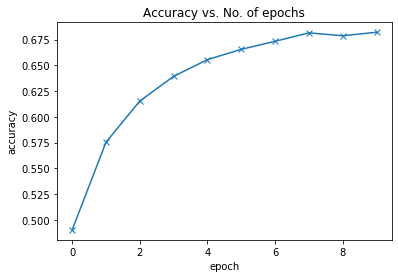

In [46]:
model = Net(n_out)
model.to(device)
history = train_model(train_dl, val_dl, 10, model, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=1e-5))
acc = get_acc(test_dl, model)
print('Accuracy: %.3f' % acc)
plot_accuracies(history)

epoch: 0 Loss after mini-batch 0: 2.300356388092041
epoch: 0 Loss after mini-batch 100: 2.2805206775665283
epoch: 0 Loss after mini-batch 200: 2.2354207038879395
epoch: 0 Loss after mini-batch 300: 2.1789424419403076
epoch: 0 accuracy: 0.2996
epoch: 1 Loss after mini-batch 0: 2.1503982543945312
epoch: 1 Loss after mini-batch 100: 2.09623122215271
epoch: 1 Loss after mini-batch 200: 2.0564143657684326
epoch: 1 Loss after mini-batch 300: 1.9305115938186646
epoch: 1 accuracy: 0.3432
epoch: 2 Loss after mini-batch 0: 1.882385015487671
epoch: 2 Loss after mini-batch 100: 1.7947533130645752
epoch: 2 Loss after mini-batch 200: 1.8308172225952148
epoch: 2 Loss after mini-batch 300: 1.7687753438949585
epoch: 2 accuracy: 0.3896
epoch: 3 Loss after mini-batch 0: 1.7353147268295288
epoch: 3 Loss after mini-batch 100: 1.728226661682129
epoch: 3 Loss after mini-batch 200: 1.6274315118789673
epoch: 3 Loss after mini-batch 300: 1.4315558671951294
epoch: 3 accuracy: 0.4272
epoch: 4 Loss after mini-batc

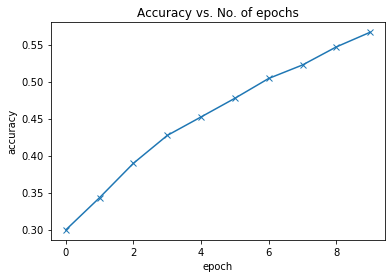

In [48]:
model = Net(n_out)
model.to(device)
history = train_model(train_dl, val_dl, 10, model, nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=1e-3))
acc = get_acc(test_dl, model)
print('Accuracy: %.3f' % acc)
plot_accuracies(history)